## Imports

In [1]:
import argparse
import logging
import os
import torch

import numpy as np
from datasets import load_from_disk
from transformers import (
    AutoModelForSeq2SeqLM,
    AutoTokenizer,
    DataCollatorForSeq2Seq,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
    BitsAndBytesConfig,
    AutoModel,
    AutoConfig
)
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training, TaskType

def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )


## Set up CometKiwi base model

In [2]:
from comet import download_model, load_from_checkpoint

# Import CometKiwi Model
model_path = download_model("Unbabel/wmt22-cometkiwi-da")
model = load_from_checkpoint(model_path)

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Lightning automatically upgraded your loaded checkpoint from v1.8.2 to v2.4.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../../../.cache/huggingface/hub/models--Unbabel--wmt22-cometkiwi-da/snapshots/b3a8aea5a5fc22db68a554b92b3d96eb6ea75cc9/checkpoints/model.ckpt`
Encoder model frozen.
/home/neko/miniconda3/envs/723project/lib/python3.8/site-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']


In [3]:
print_trainable_parameters(model)

trainable params: 6296603 || all params: 565137435 || trainable%: 1.114171988978221


## Finetuning Multilingual Uncased Bert Model

### Training Dataset

In [27]:
from datasets import load_dataset
from datasets import Dataset
import pandas as pd

# Data preprocessing

# training dataset
# en-de
training_dataset = pd.read_csv('wmt-qe-2022-data/train-dev_data/task1_da/train/en-de/en-de-train/train.ende.df.short.tsv', sep='\t', on_bad_lines='skip')

# en-zh
df = pd.read_csv('wmt-qe-2022-data/train-dev_data/task1_da/train/en-zh/en-zh-train/train.enzh.df.short.tsv', sep='\t', on_bad_lines='skip')
training_dataset = pd.concat((training_dataset, df))

# et-en
df = pd.read_csv('wmt-qe-2022-data/train-dev_data/task1_da/train/et-en/et-en-train/train.eten.df.short.tsv', sep='\t', on_bad_lines='skip')
training_dataset = pd.concat((training_dataset, df))

# ne-en
df = pd.read_csv('wmt-qe-2022-data/train-dev_data/task1_da/train/ne-en/ne-en-train/train.neen.df.short.tsv', sep='\t', on_bad_lines='skip')
training_dataset = pd.concat((training_dataset, df))

# ro-en
df = pd.read_csv('wmt-qe-2022-data/train-dev_data/task1_da/train/ro-en/ro-en-train/train.roen.df.short.tsv', sep='\t', on_bad_lines='skip')
training_dataset = pd.concat((training_dataset, df))

# ru-en
df = pd.read_csv('wmt-qe-2022-data/train-dev_data/task1_da/train/ru-en/ru-en-train/train.ruen.df.short.tsv', sep='\t', on_bad_lines='skip')
training_dataset = pd.concat((training_dataset, df))

# si-en; this language can't be tokenized for some reason
#df = pd.read_csv('wmt-qe-2022-data/train-dev_data/task1_da/train/si-en/si-en-train/train.sien.df.short.tsv', sep='\t', on_bad_lines='skip')
#training_dataset = pd.concat((training_dataset, df))
training_dataset.reset_index(drop=True, inplace=True)

training_dataset = training_dataset[['original','translation','mean']]
training_dataset['mean'] = pd.to_numeric(training_dataset['mean'], errors='coerce')
training_dataset.dropna(inplace=True)
training_dataset.to_csv('train.csv')
print(f'{len(training_dataset)} samples in training dataset')
training_dataset.head()

40898 samples in training dataset


,original,translation,mean
0,José Ortega y Gasset visited Husserl at Freibu...,1934 besuchte José Ortega y Gasset Husserl in ...,100.000000
1,"However, a disappointing ninth in China meant ...",Eine enttäuschende Neunte in China bedeutete j...,72.666667
2,"In his diary, Chase wrote that the release of ...","In seinem Tagebuch, Chase schrieb, dass die Ve...",48.666667
3,Heavy arquebuses mounted on wagons were called...,Schwere Arquebuses auf Waggons montiert wurden...,67.000000
4,Once North Pacific salmon die off after spawni...,Sobald der nordpazifische Lachs nach dem Laich...,89.000000


### Evaluation Dataset

In [26]:
# Data Preprocessing

# Evaluation Dataset
# en-de
validation_dataset = pd.read_csv('wmt-qe-2022-data/train-dev_data/task1_da/train/en-de/en-de-dev/dev.ende.df.short.tsv', sep='\t', on_bad_lines='skip')

# en-zh
df = pd.read_csv('wmt-qe-2022-data/train-dev_data/task1_da/train/en-zh/en-zh-dev/dev.enzh.df.short.tsv', sep='\t', on_bad_lines='skip')
validation_dataset = pd.concat((validation_dataset, df))

# et-en
df = pd.read_csv('wmt-qe-2022-data/train-dev_data/task1_da/train/et-en/et-en-dev/dev.eten.df.short.tsv', sep='\t', on_bad_lines='skip')
validation_dataset = pd.concat((validation_dataset, df))

# ne-en
df = pd.read_csv('wmt-qe-2022-data/train-dev_data/task1_da/train/ne-en/ne-en-dev/dev.neen.df.short.tsv', sep='\t', on_bad_lines='skip')
validation_dataset = pd.concat((validation_dataset, df))

# ro-en
df = pd.read_csv('wmt-qe-2022-data/train-dev_data/task1_da/train/ro-en/ro-en-dev/dev.roen.df.short.tsv', sep='\t', on_bad_lines='skip')
validation_dataset = pd.concat((validation_dataset, df))

# ru-en
df = pd.read_csv('wmt-qe-2022-data/train-dev_data/task1_da/train/ru-en/ru-en-dev/dev.ruen.df.short.tsv', sep='\t', on_bad_lines='skip')
validation_dataset = pd.concat((validation_dataset, df))

# si-en
#df = pd.read_csv('wmt-qe-2022-data/train-dev_data/task1_da/train/si-en/si-en-dev/dev.sien.df.short.tsv', sep='\t', on_bad_lines='skip')
#validation_dataset = pd.concat((validation_dataset, df))
validation_dataset.reset_index(drop=True, inplace=True)

validation_dataset = validation_dataset[['original','translation','mean']]
validation_dataset['mean'] = pd.to_numeric(validation_dataset['mean'], errors='coerce')
validation_dataset.dropna(inplace=True)
validation_dataset.to_csv('validation.csv')

print(f'{len(validation_dataset)} samples in validation dataset')
validation_dataset.head()

5842 samples in validation dataset


,original,translation,mean
0,"Simultaneously, the Legion took part to the pa...",Gleichzeitig nahm die Legion an der Befriedung...,64.166667
1,He also begins an affair with Veronica Harring...,Er beginnt auch eine Affäre mit Veronica Harri...,83.500000
2,The urban morphology of these two local waters...,Die urbane Morphologie dieser beiden lokalen W...,92.833333
3,Important finds included a bronze axe in Wellw...,Wichtige Funde waren eine Bronzeaxt in Wellwoo...,95.166667
4,"Previously, Englishmen had drunk mainly dark s...",Früher hatten Engländer vor allem dunkle Stout...,51.833333


### Test Dataset

In [25]:
# Data Processing

# Testing Dataset
# en-de
test_dataset = pd.read_csv('wmt-qe-2022-data/train-dev_data/task1_da/train/en-de/en-de/test20.ende.df.short.tsv', sep='\t', on_bad_lines='skip')

# en-zh
df = pd.read_csv('wmt-qe-2022-data/train-dev_data/task1_da/train/en-zh/en-zh/test20.enzh.df.short.tsv', sep='\t', on_bad_lines='skip')
test_dataset = pd.concat((test_dataset, df))

# et-en
df = pd.read_csv('wmt-qe-2022-data/train-dev_data/task1_da/train/et-en/et-en/test20.eten.df.short.tsv', sep='\t', on_bad_lines='skip')
test_dataset = pd.concat((test_dataset, df))

# ne-en
df = pd.read_csv('wmt-qe-2022-data/train-dev_data/task1_da/train/ne-en/ne-en/test20.neen.df.short.tsv', sep='\t', on_bad_lines='skip')
test_dataset = pd.concat((test_dataset, df))

# ro-en
df = pd.read_csv('wmt-qe-2022-data/train-dev_data/task1_da/train/ro-en/ro-en/test20.roen.df.short.tsv', sep='\t', on_bad_lines='skip')
test_dataset = pd.concat((test_dataset, df))

# ru-en
df = pd.read_csv('wmt-qe-2022-data/train-dev_data/task1_da/train/ru-en/ru-en/test20.ruen.df.short.tsv', sep='\t', on_bad_lines='skip')
test_dataset = pd.concat((test_dataset, df))

# si-en
#df = pd.read_csv('wmt-qe-2022-data/train-dev_data/task1_da/train/si-en/si-en/test20.sien.df.short.tsv', sep='\t', on_bad_lines='skip')
#test_dataset = pd.concat((test_dataset, df))
test_dataset.reset_index(drop=True, inplace=True)

test_dataset = test_dataset[['original','translation','mean']]
test_dataset['mean'] = pd.to_numeric(test_dataset['mean'], errors='coerce')
test_dataset.dropna(inplace=True)
test_dataset.to_csv('test.csv')
print(f'{len(test_dataset)} sammples in testing dataset')
test_dataset.head()

5993 sammples in testing dataset


,original,translation,mean
0,"The Sultan appoints judges, and can grant pard...",Der Sultan ernennt Richter und kann Begnadigun...,92.666667
1,Antisemitism in modern Ukraine Antisemitism an...,Antisemitismus in der modernen Ukraine Antisem...,89.833333
2,"Morales continued his feud with Buddy Rose, de...",Morales setzte seine Fehde mit Buddy Rose fort...,99.166667
3,American Maury Tripp attended the Jamboree fro...,Der Amerikaner Maury Tripp besuchte das Jambor...,89.666667
4,He bowled a series of bouncers at Viv Richards...,Er boomte eine Reihe von Bouncern bei Viv Rich...,69.000000


### Convert to HuggingFace dataloaders

In [2]:
from datasets import load_dataset
from datasets import Dataset
import pandas as pd

train_dataset = pd.read_csv('train.csv')
train_dataset = Dataset.from_pandas(train_dataset)

validation_dataset = pd.read_csv('validation.csv')
validation_dataset = Dataset.from_pandas(validation_dataset)

test_dataset = pd.read_csv('test.csv')
test_dataset = Dataset.from_pandas(test_dataset)

### Tokenize Dataloaders

In [3]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-multilingual-uncased")

def tokenize_function(examples):
    return tokenizer(examples["original"], examples["translation"], padding="max_length", truncation=True)

train_dataset = train_dataset.map(tokenize_function, batched=True)
validation_dataset = validation_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)
print('Vocab size: ',tokenizer.vocab_size)

Map:   0%|          | 0/40898 [00:00<?, ? examples/s]

Map:   0%|          | 0/5842 [00:00<?, ? examples/s]

Map:   0%|          | 0/5993 [00:00<?, ? examples/s]

Vocab size:  105879


In [4]:
# Remove irrelvant columns
train_dataset = train_dataset.remove_columns(['Unnamed: 0','original','translation'])
validation_dataset = validation_dataset.remove_columns(['Unnamed: 0','original','translation'])
test_dataset = test_dataset.remove_columns(['Unnamed: 0','original','translation'])

# Rename column names to correct format
train_dataset = train_dataset.rename_column("mean", "labels")
validation_dataset = validation_dataset.rename_column("mean", "labels")
test_dataset = test_dataset.rename_column("mean", "labels")

# Format lists to torch tensors
train_dataset.set_format("torch")
validation_dataset.set_format("torch")
test_dataset.set_format("torch")

In [5]:
# small subset of entire training data for testing the training process

train_dataset = train_dataset.shuffle(seed=42).select(range(1000))
validation_dataset = validation_dataset.shuffle(seed=42).select(range(100))
test_dataset = test_dataset.shuffle(seed=42).select(range(100))

### Create Torch Dataloaders

In [5]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=8)
eval_dataloader = DataLoader(validation_dataset, batch_size=8)

### Load Bert Model

In [6]:
from transformers import AutoModelForSequenceClassification

bert_model = AutoModelForSequenceClassification.from_pretrained("google-bert/bert-base-multilingual-uncased", num_labels=1)
print_trainable_parameters(bert_model)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-multilingual-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 167357185 || all params: 167357185 || trainable%: 100.0


In [7]:
from torch.optim import AdamW

optimizer = AdamW(bert_model.parameters(), lr=5e-5)

In [8]:
from transformers import get_scheduler

num_epochs = 20
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

In [9]:
import torch

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
bert_model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(105879, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

In [10]:
from tqdm.auto import tqdm
import csv

with open('log.csv', 'w', newline='') as f:
   writer = csv.writer(f)
   writer.writerow(['epoch', 'train_loss', 'valid_loss'])

for epoch in range(num_epochs):
    train_losses = []
    valid_losses = []
    
    bert_model.train()
    progress_bar = tqdm(range(len(train_dataloader)+len(eval_dataloader)))
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        
        outputs = bert_model(**batch)
        loss = outputs.loss
        train_losses.append(loss)
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

    bert_model.eval()
    for batch in eval_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = bert_model(**batch)
            loss = outputs.loss
            valid_losses.append(loss)
            progress_bar.update(1)
            
    train_loss = sum(train_losses)/len(train_losses)
    valid_loss = sum(valid_losses)/len(valid_losses)
    print(f'epoch {epoch+1}: training loss: {train_loss} validation loss: {valid_loss}')
    with open('log.csv', 'a', newline='') as f:
       writer = csv.writer(f)
       writer.writerow([epoch+1, train_loss.item(), valid_loss.item()])
        

  0%|          | 0/5844 [00:00<?, ?it/s]

epoch 1: training loss: 1044.8876953125 validation loss: 644.523193359375


  0%|          | 0/5844 [00:00<?, ?it/s]

epoch 2: training loss: 694.820556640625 validation loss: 644.5092163085938


  0%|          | 0/5844 [00:00<?, ?it/s]

epoch 3: training loss: 694.7403564453125 validation loss: 649.2613525390625


  0%|          | 0/5844 [00:00<?, ?it/s]

epoch 4: training loss: 695.015869140625 validation loss: 646.1154174804688


  0%|          | 0/5844 [00:00<?, ?it/s]

epoch 5: training loss: 694.7584838867188 validation loss: 643.9199829101562


  0%|          | 0/5844 [00:00<?, ?it/s]

epoch 6: training loss: 694.7735595703125 validation loss: 645.4652099609375


  0%|          | 0/5844 [00:00<?, ?it/s]

epoch 7: training loss: 694.47509765625 validation loss: 642.8297729492188


  0%|          | 0/5844 [00:00<?, ?it/s]

epoch 8: training loss: 694.9702758789062 validation loss: 645.932373046875


  0%|          | 0/5844 [00:00<?, ?it/s]

epoch 9: training loss: 694.7136840820312 validation loss: 649.2079467773438


  0%|          | 0/5844 [00:00<?, ?it/s]

epoch 10: training loss: 694.8974609375 validation loss: 646.045654296875


  0%|          | 0/5844 [00:00<?, ?it/s]

epoch 11: training loss: 694.8883666992188 validation loss: 644.5172729492188


  0%|          | 0/5844 [00:00<?, ?it/s]

epoch 12: training loss: 694.6077880859375 validation loss: 650.3016967773438


  0%|          | 0/5844 [00:00<?, ?it/s]

epoch 13: training loss: 695.1172485351562 validation loss: 647.927734375


  0%|          | 0/5844 [00:00<?, ?it/s]

epoch 14: training loss: 694.974609375 validation loss: 646.2256469726562


  0%|          | 0/5844 [00:00<?, ?it/s]

epoch 15: training loss: 694.9744262695312 validation loss: 646.5419311523438


  0%|          | 0/5844 [00:00<?, ?it/s]

epoch 16: training loss: 694.7938842773438 validation loss: 647.4080810546875


  0%|          | 0/5844 [00:00<?, ?it/s]

epoch 17: training loss: 694.8079833984375 validation loss: 645.3871459960938


  0%|          | 0/5844 [00:00<?, ?it/s]

epoch 18: training loss: 694.0003662109375 validation loss: 646.4019775390625


  0%|          | 0/5844 [00:00<?, ?it/s]

epoch 19: training loss: 694.5654296875 validation loss: 646.535400390625


  0%|          | 0/5844 [00:00<?, ?it/s]

epoch 20: training loss: 694.3829345703125 validation loss: 646.3471069335938


In [11]:
# save model
torch.save(bert_model, 'finetuned_Bert.pth')

### Plot train and validation loss graph

<Axes: >

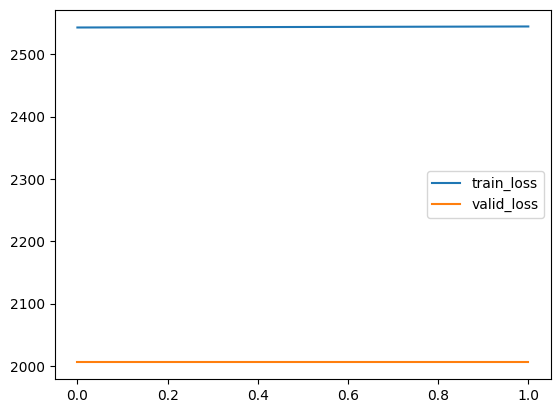

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
train_log = pd.read_csv('log.csv')
train_log = train_log[['train_loss','valid_loss']]
train_log.plot()

## Set up data for predictions

In [6]:
import pandas as pd

mt_path = 'test_data_2023/task1_sentence_level/en-de/test.ende.final.mt'
src_path = 'test_data_2023/task1_sentence_level/en-de/test.ende.final.src'
with open(mt_path, 'r') as f:
    mt = f.read().splitlines()
    f.close()
with open(mt_path, 'r') as f:
    src = f.read().splitlines()
    f.close

data = []
if len(mt) == len(src):
    for (m,s) in list(zip(mt,src)):
        d = {}
        d['mt'] = m
        d['src'] = s
        data.append(d)
else:
    print('length of mt and src do not match')

In [9]:
base_model_output = model.predict(data, batch_size=8, gpus=1)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████| 238/238 [00:11<00:00, 19.94it/s]


In [ ]:
base_model_output

## Apply LoRa to model

In [11]:
lora_model = prepare_model_for_kbit_training(model)

In [14]:
config = LoraConfig(
        r=16, 
        target_modules = ['query','key','value']
    )

lora_model = get_peft_model(lora_model, config)

In [15]:
print_trainable_parameters(lora_model)

trainable params: 2359296 || all params: 567496731 || trainable%: 0.4157373727673508


In [16]:
lora_model_output = model.predict(data, batch_size=8, gpus=1)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████| 238/238 [00:12<00:00, 18.80it/s]


In [22]:
diff_sum = 0
for (b,l) in list(zip(base_model_output['scores'], lora_model_output['scores'])):
    diff_sum += (b-l)
diff_sum

0.0